### CS268 HW1
* Name: Berkay Guler
* Department: NetSys

#### Problem 1)

**1.A - Selected Algorithm: _Golden Section Search_**

1) I used the bracketing algorithm from the K&W book to find an interval containing the minimum. 

2) Then, I used the Golden Section Search algorithm from the K&W book to narrow this interval down until the interval length is small enough.

3) Finally, taking the mid-point of the interval yields the value at which the target function approximately attains its minimum value.

4) The convergence measure used is $|x^{k} - x^{k-1}|$ where $x^{k}$ is the current  midpoint  of  the  interval

In [1]:
# for some predefined constants
using Base.MathConstants

In [2]:
function bracket_minimum(fnc, x=0; s=1e-2, k=2.0)
    # source(s) of code used = K&W Algorithms for Optimization, page 36
    a, ya = x, fnc(x)
    b, yb = a + s, fnc(a + s) 
    if yb > ya
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    end
    while true
        c, yc = b + s, fnc(b + s) 
        if yc > yb
            return a < c ? (a, c) : (c, a)
        end
        a, ya, b, yb = b, yb, c, yc
        s *= k
    end
end


function optimizer1D(
        func, initial_point, 
        initial_step_size, convergence_thr=0.00000001;)
    # optimization method used = Golden Section Search 
    # source(s) of code used = K&W Algorithms for Optimization, page 41
    
    a, b = bracket_minimum(func, initial_point, s=initial_step_size, k=2.0)
    ρ = φ - 1
    d = ρ*b + (1 - ρ)*a
    yd = func(d)
    x_estimate_curr = (a + b)/2
    x_estimate_prev = x_estimate_curr + convergence_thr + 0.0001  
    eval_count = 1
    
    while abs(x_estimate_curr - x_estimate_prev) > convergence_thr
        c = ρ*a + (1 - ρ)*b 
        yc = func(c)
        if yc < yd
            b, d, yd = d, c, yc
        else
            a, b = b, c
        end
        x_estimate_prev = x_estimate_curr
        x_estimate_curr = (a + b)/2
        eval_count += 1
    end
    return x_estimate_curr, abs(x_estimate_curr - x_estimate_prev), eval_count
    
end

optimizer1D (generic function with 2 methods)

**1.B - Finding the Ground Truth Minima**

All test functions $f, g, h$ are unimodal and have an exact global minima. Hence, derivative information can be used to find the exact minima for each.
$$f'(x) = 0 \implies x^* = 2$$
$$g'(x) = 0 \implies x^* = \sqrt[3]{2}$$
$$h'(x) = 0 \implies x^* = \ln(1 + \sqrt{2})$$

In [3]:
# 1-D test functions
f(x) = 1/2*x^2 - 2*x + 2
g(x) = (1/4)*x^4 - 2*x
h(x) = ℯ^x + ℯ^(-x) - 2*x

h (generic function with 1 method)

In [4]:
println("Minimum value of f = ", f(2))
println("Minimum value of g = ", g(2^(1/3)))
println("Minimum value of h = ", h(log(1 + 2^(1/2))))

Minimum value of f = 0.0
Minimum value of g = -1.8898815748423097
Minimum value of h = 1.065679950707104


**1.C - Generating Test Points**

Now, we sample 100 numbers from the uniform distribution from -10 to 10 for f and g; and from -2 to 2 for h. The sampled points are raised to the power of $e$ with - and + sign, selected randomly.

In [5]:
function sample_exp_uniform(num_samples=100, range=10)
    # sample num_samples numbers from [-range, range]
    x = range*(rand(num_samples)) .* rand((-1, 1), num_samples)
    # raise to the power of e and select a random sign
    y = e.^x .* rand((-1, 1), 100)
    return y
end

sample_exp_uniform (generic function with 3 methods)

**1.D - Calculating Statistics**
* _Statistics.std_ method uses Bessel Correction by default to calculate sample standart deviation 

In [6]:
using Statistics
using TypedTables

In [7]:
f_samples = sample_exp_uniform(100, 10)
g_samples = sample_exp_uniform(100, 10)
h_samples = sample_exp_uniform(100, 2)
gt_values = (f(2), g(2^(1/3)), h(log(1 + 2^(1/2))))
iter = zip(
    (f_samples, g_samples, h_samples), 
    (f, g ,h), gt_values, ["f", "g", "h"])        

mean_error_col = []
mean_conv_col = []
mean_eval_col = []
mean_time_col = []
std_error_col = []
std_conv_col = []
std_eval_col = []
std_time_col = []

for (samples, curr_f, gt_value, f_name) in iter
    arr_convergence_measure = []
    arr_error = []
    arr_num_eval = []
    arr_time = []
    for x_i in samples
        tic = time()
        estimated_min, conv_measure, num_evals = optimizer1D(curr_f, x_i, 1e-2)
        elapsed_time = (time() - tic) * 1000
        absolute_error = abs(gt_value - curr_f(estimated_min))
        append!(arr_error, absolute_error)
        append!(arr_convergence_measure, conv_measure)
        append!(arr_num_eval, num_evals)
        append!(arr_time, elapsed_time)
    end
    append!(mean_error_col, mean(arr_error))
    append!(mean_conv_col, mean(arr_convergence_measure))
    append!(mean_eval_col, mean(arr_num_eval))
    append!(mean_time_col, mean(arr_time))
    append!(std_error_col, std(arr_error))
    append!(std_conv_col, std(arr_convergence_measure))
    append!(std_eval_col, std(arr_num_eval))
    append!(std_time_col, std(arr_time))
end

### Reporting Mean

In [8]:
mean_table = Table(Func = ["f", "g", "h"], Err = mean_error_col,
            Convergence = mean_conv_col, evaluations = mean_eval_col,
            time_ms = mean_time_col)

Table with 5 columns and 3 rows:
     Func  Err          Convergence  evaluations  time_ms
   ┌──────────────────────────────────────────────────────
 1 │ f     6.66134e-18  8.1211e-9    43.93        0.414886
 2 │ g     2.88658e-17  7.51439e-9   44.34        0.224111
 3 │ h     1.70974e-16  7.47349e-9   38.5         0.222878

### Reporting Standard Deviation

In [9]:
std_table = Table(Func = ["f", "g", "h"], Err = std_error_col,
            Convergence = std_conv_col, evaluations = std_eval_col,
            time_ms = std_time_col)

Table with 5 columns and 3 rows:
     Func  Err          Convergence  evaluations  time_ms
   ┌─────────────────────────────────────────────────────
 1 │ f     4.94497e-17  9.93876e-10  5.98357      4.1381
 2 │ g     8.73193e-17  1.08534e-9   6.85819      2.22827
 3 │ h     2.04179e-16  9.712e-10    2.35488      2.21272

#### Problem 2)
**2.A - Test Functions**

*Booth's Function:* Test function selected from appendix B of K&W page 426. The formula for this function is:
$$f(x_1, x_2) = (x_1+2x_2-7)^2 + (2x_1+x_2-5)^2$$
where $f(1,3) = 0$ is the global minimum.

*Rosenbrock's Banana Function:* Test function selected from appendix B of K&W page 430. The formula for this function is:
$$f(x_1, x_2) = (a-x_1)^2 + b(x_2-x_1^2)^2$$
where $f(1,1) = 0$ is the global minimum for $a=1$ and $b=5$.

In [10]:
booths(x, y) = (x + 2y - 7)^2 + (2x + y - 5)^2

a = 1
b = 5
rosenbrock(x, y) = (a - x)^2 + b*(y - x^2)^2

rosenbrock (generic function with 1 method)

**2.B - Coordinate Descent Algorithm in 2-D**

Coordinate descent algorithm fixes all axes and optimizes a function along a chosen dimension. For the case of functions of two variables $f(x, y)$ we can define the functions $$g(x) = f(x, y)$$ and $$h(y) = f(x, y)$$ 

We can first optimize $g(x) = f(x, y_i)$ given the starting point $y_i$. Optimizing $g(x)$ yields the value $x_{new}$ at which $g(x)$ attains its minimum value. Then we can optimize $h(y) = f(x_{new}, y)$. Alternating between optimizing $g$ and $h$ and using the values obtained in the previous iteration as a reference results in optimizing $f$ in 2-D.

In [11]:
function coordinate_descent(f, x, y, conv_thr)
    eval_count = 0
    while true
        g(x) = f(x, y)
        # optimize along x axis for fixed y
        x_new, _, _ = optimizer1D(g, x, 0.1)
        # optimize along y axis for fixed x
        h(y) = f(x_new, y)
        y_new, _, _ = optimizer1D(h, y, 0.1)
        eval_count += 2
        conv_measure = ((x_new - x)^2 + (y_new - y)^2)^(1/2)
        if conv_measure < conv_thr
            return (x_new, y_new), conv_measure, eval_count
        end
        
        x, y = x_new, y_new
    end
end

coordinate_descent (generic function with 1 method)

**2.C - Sampling Test Points**

I am using the same procedure used in _Problem 1_ to generate test points $(x_i, y_i)$ for $i = 1, 2, ..., 100$

**2.D - Calculating Statistics**

Using the same procedure as in _Problem 1_ below I report a 2x4 table.

In [12]:
rosenbrock_x = sample_exp_uniform(100, 10)
rosenbrock_y = sample_exp_uniform(100, 10)
booths_x = sample_exp_uniform(100, 10)
booths_y = sample_exp_uniform(100, 10)

gt_values = (booths(1,3), rosenbrock(1,1))
iter = zip(
    ((booths_x, booths_y), (rosenbrock_x, rosenbrock_y)), 
    (booths, rosenbrock), gt_values, ("Booth's", "Rosenbrock")
    )

mean_error_col = []
mean_conv_col = []
mean_eval_col = []
mean_time_col = []
std_error_col = []
std_conv_col = []
std_eval_col = []
std_time_col = []

for (samples, curr_f, gt_value, f_name) in iter
    arr_convergence_measure = []
    arr_error = []
    arr_num_eval = []
    arr_time = []

    for sample in samples
        x_i, y_i = sample
        tic = time()
        estimated_min, conv_measure, num_evals = coordinate_descent(curr_f, x_i, y_i, 1e-7)
        elapsed_time = (time() - tic) * 1000
        absolute_error = abs(gt_value - curr_f(estimated_min...))
        append!(arr_error, absolute_error)
        append!(arr_convergence_measure, conv_measure)
        append!(arr_num_eval, num_evals)
        append!(arr_time, elapsed_time)
    end
    append!(mean_error_col, mean(arr_error))
    append!(mean_conv_col, mean(arr_convergence_measure))
    append!(mean_eval_col, mean(arr_num_eval))
    append!(mean_time_col, mean(arr_time))
    append!(std_error_col, std(arr_error))
    append!(std_conv_col, std(arr_convergence_measure))
    append!(std_eval_col, std(arr_num_eval))
    append!(std_time_col, std(arr_time))
        
end

### Reporting Mean

In [13]:
mean_table = Table(Func = ["Booth's", "Rosenbrock"], Err = mean_error_col,
            Convergence = mean_conv_col, evaluations = mean_eval_col,
            time = mean_time_col)

Table with 5 columns and 2 rows:
     Func        Err          Convergence  evaluations  time
   ┌───────────────────────────────────────────────────────────
 1 │ Booth's     1.76719e-14  5.67765e-8   90.0         54.3414
 2 │ Rosenbrock  7.95333e-13  9.18143e-8   513.0        68.037

### Reporting Standard Deviation

In [14]:
std_table = Table(Func = ["Booth's", "Rosenbrock"], Err = std_error_col,
            Convergence = std_conv_col, evaluations = std_eval_col,
            time = std_time_col)

Table with 5 columns and 2 rows:
     Func        Err          Convergence  evaluations  time
   ┌───────────────────────────────────────────────────────────
 1 │ Booth's     6.74508e-15  1.20305e-8   16.9706      76.5675
 2 │ Rosenbrock  6.68598e-15  0.0          1.41421      91.4954

--------------------------------------------------------------------------------

# Extras
**Investigating the Effect of Convergence Threshold on Absolute Error**
* Lower convergence thresholds results in smaller absolute error. However required number of function evaluations increases with decreasing convergence threshold. Here I demonstrate this via changes in mean error in the plots below.
* Lowering the convergence threshold results in a smaller standard deviation as shown by error bars. This is because the approximation to the minimum of the optimized function becomes less accurate with increasing convergence threshold and hence variance is higher.

### Observations on Problem 1

In [15]:
conv_thrs = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]

f_samples = sample_exp_uniform(100, 10)
g_samples = sample_exp_uniform(100, 10)
h_samples = sample_exp_uniform(100, 2)
gt_values = (f(2), g(2^(1/3)), h(log(1 + 2^(1/2))))
        
iter = zip(
    (f_samples, g_samples, h_samples), 
    (f, g ,h), gt_values, ["f", "g", "h"])        

mean_error_col = []
mean_conv_col = []
mean_eval_col = []
mean_time_col = []
std_error_col = []
std_conv_col = []
std_eval_col = []
std_time_col = []


for conv_thr in conv_thrs
    for (samples, curr_f, gt_value, f_name) in iter
        arr_convergence_measure = []
        arr_error = []
        arr_num_eval = []
        arr_time = []
        for x_i in samples
            tic = time()
            estimated_min, conv_measure, num_evals = optimizer1D(
                curr_f, x_i, 1e-2, conv_thr
            )
            elapsed_time = (time() - tic) * 1000
            absolute_error = abs(gt_value - curr_f(estimated_min))
            append!(arr_error, absolute_error)
            append!(arr_convergence_measure, conv_measure)
            append!(arr_num_eval, num_evals)
            append!(arr_time, elapsed_time)
        end
        append!(mean_error_col, mean(arr_error))
        append!(mean_conv_col, mean(arr_convergence_measure))
        append!(mean_eval_col, mean(arr_num_eval))
        append!(mean_time_col, mean(arr_time))
        append!(std_error_col, std(arr_error))
        append!(std_conv_col, std(arr_convergence_measure))
        append!(std_eval_col, std(arr_num_eval))
        append!(std_time_col, std(arr_time))
    end
end

In [16]:
# absolute error for f
f_mean_error_col = [mean_error_col[i] for i in 1:length(mean_error_col) if i % 3 == 1 ]
f_std_error_col = [std_error_col[i] for i in 1:length(mean_error_col) if i % 3 == 1 ]

# required function evaluations for f
f_mean_eval_col = [mean_eval_col[i] for i in 1:length(mean_error_col) if i % 3 == 1 ]
f_std_eval_col = [std_eval_col[i] for i in 1:length(mean_error_col) if i % 3 == 1 ]

8-element Vector{Float64}:
 6.361651205513086
 6.260344973874778
 6.331092107427219
 6.448952620308969
 6.331092107427219
 6.477622708957043
 6.360952536508756
 6.331092107427219

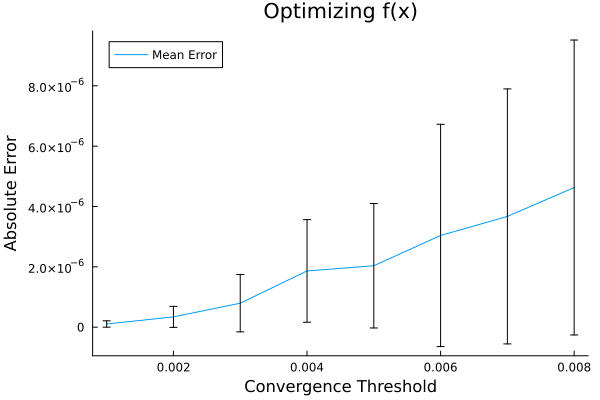

In [17]:
using Plots
plot(
    conv_thrs, f_mean_error_col, grid=false,
    yerror=f_std_error_col, labels="Mean Error",
    xlabel="Convergence Threshold",  ylabel="Absolute Error", title="Optimizing f(x)")

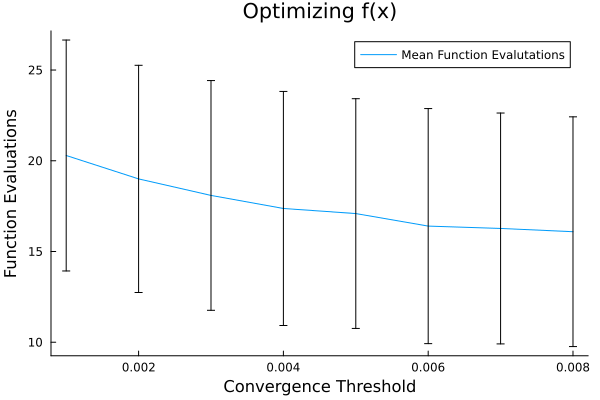

In [18]:
plot(
    conv_thrs, f_mean_eval_col, grid=false,
    yerror=f_std_eval_col, labels="Mean Function Evalutations",
    xlabel="Convergence Threshold",  ylabel="Function Evaluations", title="Optimizing f(x)")

### Observations on Problem 2

In [19]:
conv_thrs = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]

rosenbrock_x = sample_exp_uniform(100, 10)
rosenbrock_y = sample_exp_uniform(100, 10)
booths_x = sample_exp_uniform(100, 10)
booths_y = sample_exp_uniform(100, 10)

gt_values = (booths(1,3), rosenbrock(1,1))
iter = zip(
    ((booths_x, booths_y), (rosenbrock_x, rosenbrock_y)), 
    (booths, rosenbrock), gt_values, ("Booth's", "Rosenbrock")
    )

mean_error_col = []
mean_conv_col = []
mean_eval_col = []
mean_time_col = []
std_error_col = []
std_conv_col = []
std_eval_col = []
std_time_col = []

for conv_thr in conv_thrs
    for (samples, curr_f, gt_value, f_name) in iter
        arr_convergence_measure = []
        arr_error = []
        arr_num_eval = []
        arr_time = []

        for sample in samples
            x_i, y_i = sample
            tic = time()
            estimated_min, conv_measure, num_evals = coordinate_descent(curr_f, x_i, y_i, conv_thr)
            elapsed_time = (time() - tic) * 1000
            absolute_error = abs(gt_value - curr_f(estimated_min...))
            append!(arr_error, absolute_error)
            append!(arr_convergence_measure, conv_measure)
            append!(arr_num_eval, num_evals)
            append!(arr_time, elapsed_time)
        end
        append!(mean_error_col, mean(arr_error))
        append!(mean_conv_col, mean(arr_convergence_measure))
        append!(mean_eval_col, mean(arr_num_eval))
        append!(mean_time_col, mean(arr_time))
        append!(std_error_col, std(arr_error))
        append!(std_conv_col, std(arr_convergence_measure))
        append!(std_eval_col, std(arr_num_eval))
        append!(std_time_col, std(arr_time))
    end
end

In [20]:
# absolute error for each function 
booths_mean_error_col = [mean_error_col[i] for i in 1:length(mean_error_col) if i % 2 == 1 ]
booths_std_error_col = [std_error_col[i] for i in 1:length(mean_error_col) if i % 2 == 1 ]

# required function evaluations for each function
booths_mean_eval_col = [mean_eval_col[i] for i in 1:length(mean_error_col) if i % 2 == 1 ]
booths_std_eval_col = [std_eval_col[i] for i in 1:length(mean_error_col) if i % 2 == 1 ]

8-element Vector{Float64}:
 25.45584412271571
 25.45584412271571
 25.45584412271571
 25.45584412271571
 25.45584412271571
 25.45584412271571
 25.45584412271571
 25.45584412271571

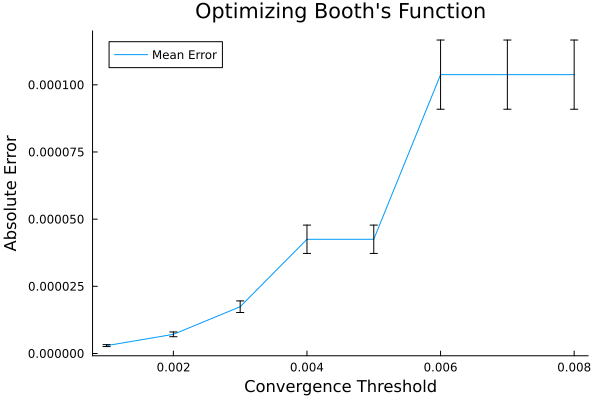

In [21]:
plot(
    conv_thrs, booths_mean_error_col, grid=false,
    yerror=booths_std_error_col, labels="Mean Error",
    xlabel="Convergence Threshold",  ylabel="Absolute Error", title="Optimizing Booth's Function")

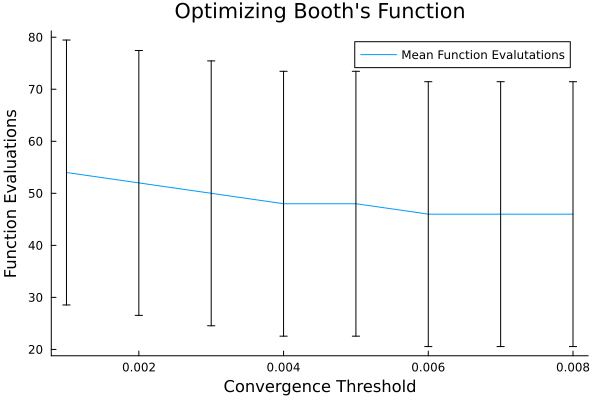

In [22]:
plot(
    conv_thrs, booths_mean_eval_col, grid=false,
    yerror=booths_std_eval_col, labels="Mean Function Evalutations",
    xlabel="Convergence Threshold",  ylabel="Function Evaluations", title="Optimizing Booth's Function")